<a href="https://colab.research.google.com/github/DavidkingMazimpaka/CHAT-BOT/blob/main/HeartDisease_Chat_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  A Health Disease Chatbot using a Transformer Model

In [2]:
!pip install datasets

In [3]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Load the dataset with pandas

df = pd.read_csv('/content/drive/MyDrive/ALU Final year ML/Summative/Heart_Diseases-QAs.csv')
df.head()

,Questions,Answers,Patterns,Tags
0,What is coronary artery disease?,Coronary artery disease (CAD) is a condition w...,What is CAD?|Can you explain coronary artery d...,Cardiovascular|CAD|Basic Concepts
1,What are the main symptoms of a heart attack?,"""The main symptoms of a heart attack include c...",What happens during a heart attack?|How do I k...,Symptoms|Emergency|Heart Attack
2,How does high blood pressure affect the heart?,"""High blood pressure forces the heart to work ...","""What damage does hypertension cause?|Effects ...",Hypertension|Risk Factors|Complications
3,What is heart failure?,Heart failure occurs when the heart muscle can...,Define heart failure|What happens in heart fai...,Heart Failure|Basic Concepts|Chronic Conditions
4,What lifestyle changes can prevent heart disease?,Key lifestyle changes include maintaining a he...,How to prevent heart disease?|Heart disease pr...,Prevention|Lifestyle|Health Management


In [29]:
# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    questions = df['Questions'][ind].lower().replace('?', '.').split('.')
    patterns = [q.strip() for q in questions if q.strip()]
    patterns.append(df['Patterns'][ind].lower().strip())
    responses = df['Answers'][ind]
    tag = df['Tags'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)

print(dict_["intents"][:2])

with open("crops.json", "w") as f:
    json.dump(dict_, f)

[{'tags': ['Cardiovascular|CAD|Basic Concepts'], 'patterns': ['what is coronary artery disease', 'what is cad?|can you explain coronary artery disease?|define coronary artery disease'], 'responses': ['Coronary artery disease (CAD) is a condition where the blood vessels that supply blood to the heart become narrowed or blocked due to plaque buildup. This plaque consists of cholesterol, fatty deposits, and other substances that accumulate on the inner walls of arteries.']}, {'tags': ['Symptoms|Emergency|Heart Attack'], 'patterns': ['what are the main symptoms of a heart attack', "what happens during a heart attack?|how do i know if i'm having a heart attack?|heart attack warning signs"], 'responses': ['"The main symptoms of a heart attack include chest pain or pressure, shortness of breath, pain radiating to the arm, neck, or jaw, cold sweats, nausea, and lightheadedness. Women may experience less typical symptoms like fatigue and back pain."']}]


In [30]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']
lemmatizer = WordNetLemmatizer()

# for intent in dict_['intents']:
#   for pattern in intent['patterns']:
#     if isinstance(pattern, str):
#       pattern = pattern.strip()
#       word_list = tokenizer(pattern)
#       words.extend(word_list)
#       documents.append((pattern, intent['tags']))
#       if intent['tags'] not in classes:
#         classes.append(intent['tags'])

# lemmatizer=WordNetLemmatizer()

# words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
# words = sorted(set(words))
# classes = sorted(set(classes))

# pickle.dump(words, open('words.pkl', 'wb'))
# pickle.dump(classes, open('classes.pkl', 'wb'))

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [31]:
# Prepare training data
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               98432     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 24)                1560      
                                                                 
Total params: 108,248
Trainable params: 108,248
Non-trainable params: 0
_________________________________________________________________


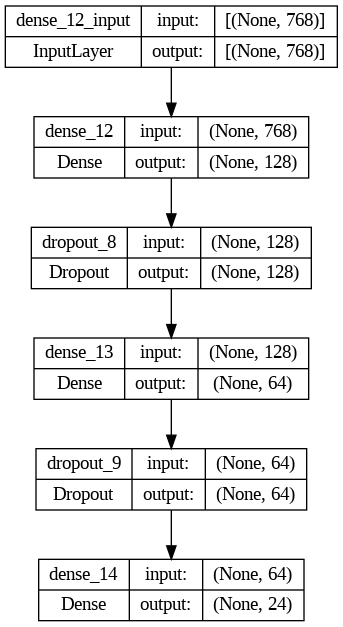

In [32]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[1]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
# sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.9,nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [33]:
# Training the model heartDiseaseChatBot.h5
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('heartDiseaseChatBot.h5', hist)
print('Training Completed')

Epoch 1/50
5/5 [==============================] - 2s 9ms/step - loss: 3.2571 - accuracy: 0.0200 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 3.0844 - accuracy: 0.0800 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 11ms/step - loss: 3.0247 - accuracy: 0.1600 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 2.9148 - accuracy: 0.2000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 2.8687 - accuracy: 0.1400 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 2.8325 - accuracy: 0.1600 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 9ms/step - loss: 2.7493 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/50


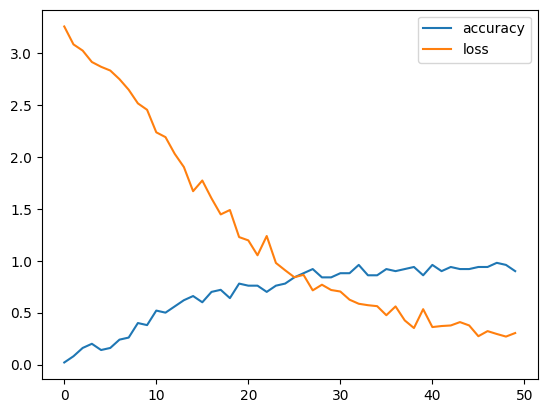

In [34]:
# Plotting the model

plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
# plt.show()
plt.legend()

## Load the Model for Prediction

In [35]:
model = load_model('heartDiseaseChatBot.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("Kudos GO! BOT IS RUNNING...")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

Kudos GO! BOT IS RUNNING...
Cardiovascular
1/1 [==============================] - 0s 91ms/step
Bot: Heart failure occurs when the heart muscle can't pump blood efficiently enough to meet the body's needs. It doesn't mean the heart has stopped but rather that it's not working as well as it should. This can result in fatigue, breathing problems, and fluid buildup.
heart failure
1/1 [==============================] - 0s 25ms/step
Bot: Heart valve disorders occur when heart valves don't work properly, either not opening fully (stenosis) or not closing properly (regurgitation). This can disrupt blood flow through the heart and affect its ability to pump efficiently.
What is an arrhythmia
1/1 [==============================] - 0s 46ms/step
Bot: An arrhythmia is an irregular heartbeat where the heart beats too fast (tachycardia), too slow (bradycardia), or with an irregular pattern. It occurs when the electrical signals controlling heartbeat don't work properly.
What is a stress test?
1/1 [==

In [36]:
from google.colab import files

# Download the model file
files.download('heartDiseaseChatBot.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>